Notebook to accompany paper in preparation by Arseniev-Koehler and Foster.
All code last checked on Python 3 in Windows 5/30/2018. Please do not cite or reuse this code yet as it is still in preparation and may contain errors. 

# More Manly or Womanly? Geometrically Identify Biases in Word2Vec Models

Using Methods inspired by [Bolukbasi et. al. 2016](https://arxiv.org/abs/1607.06520).

**Table of Contents**

* Part 1: [Motivation](#Motivation)
* Part 2: [Functions for dimensions-extraction](#HelperFunctions)
* Part 3: [Robustness checks](#Robustness)
* Part 4: [Extract a dimension and visualize how this dimension classifies words according to gender, morality, healt, and socio-econonomic status](#Results)


*This is a long notebook. Here are some possible adventures you might choose:*
    
* Get the ideas, see simple examples in Python  (Just do [Part 1](#Motivation))
* Get to the results ([Part 2](#HelperFunctions) and [4](#Results))
* Do robustness checks and then get the results ([Part 2](#HelperFunctions), [3](#Robustness), and [4](#Results)) 

In [74]:
#load up (and install if needed) libraries
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold 
from gensim.models import Word2Vec, KeyedVectors
from sklearn import preprocessing
np.set_printoptions(threshold=np.inf) #don't need this if you don't want to print full output, such as high dimensional vectors
from sklearn.decomposition import PCA 
import csv
import gensim
import statistics
from random import randint
from collections import Counter
import matplotlib.pyplot as plt
from scipy import spatial
import seaborn as sns
from pylab import rcParams
from pylab import xlim
%matplotlib inline

**Load up a pretrained Word2Vec Model**

*Don't have a model? Use a pretrained Word2Vec Model from Google, trained on Google News*
* Download a pre-trained model on GoogleNews, find link to download on this [site](https://code.google.com/archive/p/word2vec/) or direct link to [download here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing).
* Extract the files, and make sure you have the one called "GoogleNews-vectors-negative300.bin.gz" in your working directory. Your working directory is the folder where this Jupyter notebook is currently saved. Currently, the code assumes that your downloads folder is your working directory. 
* Some of the vocabulary words used in this notebook may not exist, since the vocabulary words used in this notebook were selected based on a model trained on the New York Times, however the code will still run fine. 

In [ ]:
#   An example for a PC computer if your model is in your downloads folder, and you're using the Google model 
#currentmodel=  KeyedVectors.load_word2vec_format('C:/Users/Alina Arseniev/Downloads/GoogleNews-vectors-negative300.bin.gz', binary=True)

#   An example for a Mac if your model is in your downloads folder, and you're using the Google model 
#currentmodel=  KeyedVectors.load_word2vec_format("~/Downloads/GoogleNews-vectors-negative300.bin.gz", binary=True)

#   Example based on my set-up of folders:
currentmodel=  KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)


*Have your own Word2Vec model? Load it up below.*
* Some of the vocabulary words used in this notebook may not exist, since the vocabulary words used in this notebook were selected based on a model trained on the New York Times, however the code will still run fine. You might consider curating the words more to your vocabulary, especially if many words are missing in your vocabulary. 

In [77]:
#    An example for a PC computer if your model is in your downloads folder, and you're using a model named "modelA_ALLYEARS_500dim_10CW" 
#currentmodel=  Word2Vec.load("C:/Users/Alina Arseniev/Downloads/modelA_ALLYEARS_500dim_10CW")

#   An example for a Mac if your model is in your downloads folder, and you're using a model named "modelA_ALLYEARS_500dim_10CW" 
#currentmodel=  Word2Vec.load("~/Downloads/modelA_ALLYEARS_500dim_10CW")

#   Example based on my set-up of folders:
#currentmodel=  Word2Vec.load("Word2VecModels/modelA_ALLYEARS_500dim_10CW") #load up a trained Word2Vec model. You'll need to tailor this path to your computer



<a id='Motivation'></a> 
# Part 1. Motivation

"Dimension," "direction" and "subspace" are used in this notebook interchangeably to refer to a vector that captures a bipolar concept such as gender which is often portrayed as ranging continuosly from hypermasculine to hyperfeminine, or socioeconomic status (SES) which ranges from poor to rich. 

This notebook explores how a language model (Word2Vec) **learns words with respect to these dimensions.** Word2Vec models words as numeric vectors, for a review of Word2Vec check out this [blog post](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/). We classify a word-vector by first finding the dimension (like gender), and then projecting the word-vector onto the vector representing the dimension. We get a scalar that corresponds to how far the word-vector lies at one end of the diemsnion or anotehr (e.g., how masculine or feminine the word-vector is).
* To use gender as an example - a larger, positive projection of a word onto the gender dimension suggests this word is learned as highly feminine, while a larger, negative projection of a word onto the gender dimension suggests that this word is learned as highly masculine. A word with a projection near zero suggests that Word2Vec learned this word as gender-neutral. 
* Dimensions in this juypter notebook that are ready for extraction are **gender, morality, health,** and **ses**. Code is modifiable to extract other dimensions that may be interesting: you will need to adjust the training/testing words and corresponding labels. 
* This code is written for use with Word2Vec models, modifiable for other word-vector models as well. 

For the original application of these methods to gender see [Bolukbasi et. al. 2016](https://arxiv.org/abs/1607.06520).

__*For a more visual explanation, imagine a 3-D vector space with the word-vectors for woman and man:*__

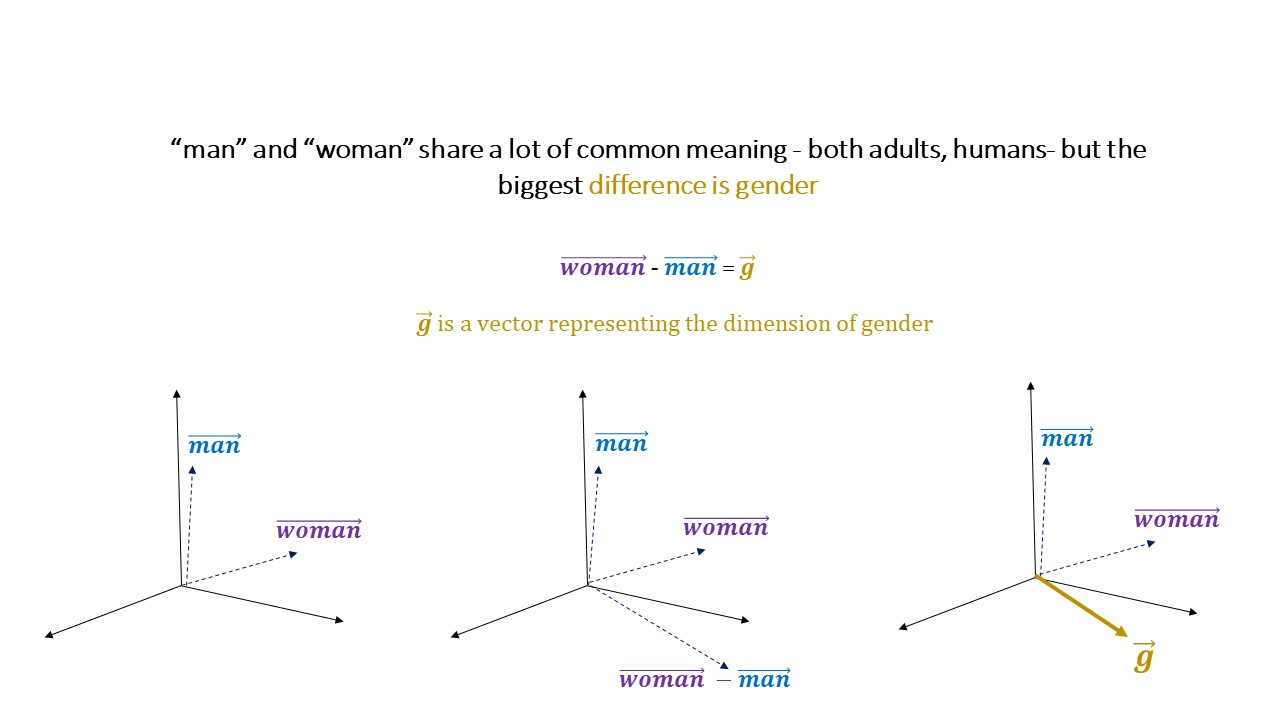

**Want MORE detail on how we can extract dimension (like gender)?**


Let's look at gender as an example. To extract a gender dimension, we want to find a direction (vector) that correspond to gender. We'll call this vector $\overrightarrow{g}$. This vector might be visualized as an axis ranging from negative (masculine) to positive (feminine) with gender-neutral at 0. We can find $\overrightarrow{g}$ by subtracting feminine word-vectors from their masculine word-vector counterparts (such as $\overrightarrow{woman}-\overrightarrow{man}$). Specifically, if we assume that the meanings of woman and man are largely equivalent (both human, adults, nouns, singular, etc.) except for their opposite gender components, then subtraction cancels out all but the gender differences across each component. This gender component is our gender direction ($\overrightarrow{g}$). 

Each word-vector in our model is made up of N components, where N is the dimensionality of the vector space. We can write each word-vectors in terms of these N components, below. For example, the first component is $\overrightarrow{X}$, the second component is $\overrightarrow{Y}$, and the Nth component is $\overrightarrow{N}$. For brevity, in the math below we refer to the word-vector for woman as $\overrightarrow{w}$ and the word-vector for man as $\overrightarrow{m}$.


$\overrightarrow{w} = w_{1}\overrightarrow{X} + w_{2}\overrightarrow{Y} + ... + w_{N}\overrightarrow{N}$
and 
$\overrightarrow{m} = m_{1}\overrightarrow{X} + m_{2}\overrightarrow{Y} + ... + m_{N}\overrightarrow{N}$


We assume that $\overrightarrow{w} - \overrightarrow{m}$ = $\overrightarrow{g}$, where $\overrightarrow{g}$ is a gender difference vector as described above.


$\overrightarrow{w} - \overrightarrow{m}$= $(w_{1}\overrightarrow{X} + w_{2}\overrightarrow{Y} + ... + w_{N}\overrightarrow{N}) - ( m_{1}\overrightarrow{X} + m_{2}\overrightarrow{Y} + ... + m_{N}\overrightarrow{N})$


These components may be rearranged:

$\overrightarrow{w} - \overrightarrow{m} = (w_{1}- m_{1})\overrightarrow{X} + (w_{2}- m_{2})\overrightarrow{Y} + ... + (w_{N} - m_{N})\overrightarrow{N}$

$\overrightarrow{w} - \overrightarrow{m} = g_{1}\overrightarrow{X} +  g_{2}\overrightarrow{Y} + ... + g_{N}\overrightarrow{N}$

This leaves us with a N-dimensional vector corresponding to the vector $\overrightarrow{g}$, corresponding to *differences* between $\overrightarrow{man}$ and $\overrightarrow{woman}$.

### Let's try extracting a gender direction from our pretrained Word2Vec model

In [193]:
gender_direction_trial= currentmodel['woman']-currentmodel['man'] #subtracting the word-vector for man from that for woman
print(gender_direction_trial) #this "direction" representing gender is just an N-dimensional vector. Not so meaningful to a human!

[ -8.30078125e-02  -2.08007812e-01  -1.37695312e-01  -2.44140625e-02
   2.83203125e-02  -6.61621094e-02   8.39843750e-02   1.87377930e-02
  -3.17382812e-02   4.66384888e-02  -1.25976562e-01  -9.37500000e-02
   2.09960938e-02   2.63671875e-02   7.49511719e-02   5.34667969e-02
  -8.98437500e-02  -1.12792969e-01   3.27148438e-02   7.00683594e-02
   1.01806641e-01  -4.93927002e-02  -8.12988281e-02  -1.36718750e-01
  -5.38330078e-02  -4.10156250e-02  -9.27734375e-02   3.90625000e-03
  -2.53906250e-02  -1.66503906e-01  -1.85546875e-02  -1.42944336e-01
  -1.61621094e-01  -8.48388672e-02  -1.95312500e-02  -1.30859375e-01
   5.85937500e-02   7.81250000e-02  -1.67480469e-01  -1.21093750e-01
  -1.88720703e-01   1.04980469e-02  -5.37109375e-02  -1.61743164e-02
  -9.27734375e-02   4.49218750e-02   0.00000000e+00   2.49023438e-02
   2.11181641e-02   1.14257812e-01   1.86279297e-01  -1.23390198e-01
  -2.44140625e-04   2.22167969e-01  -1.58691406e-01   1.31835938e-02
  -1.46484375e-02  -2.68554688e-02

### Now how do we use this gender direction to find how a word-vector is gendered? 
We [project](https://en.wikipedia.org/wiki/Vector_projection) the word-vector onto the gender direction! A more visual explantion below. 

__*Thinking more about our gender direction:*__

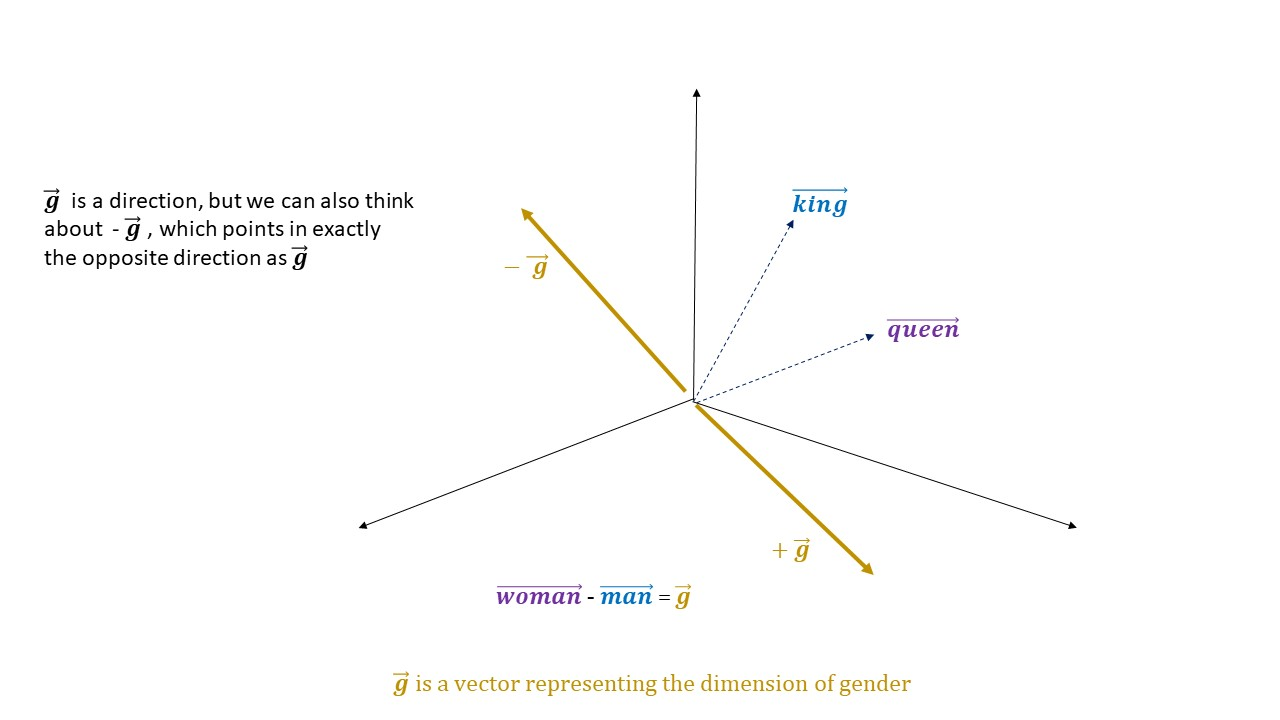

***

__*Projecting a word onto our gender direction:*__

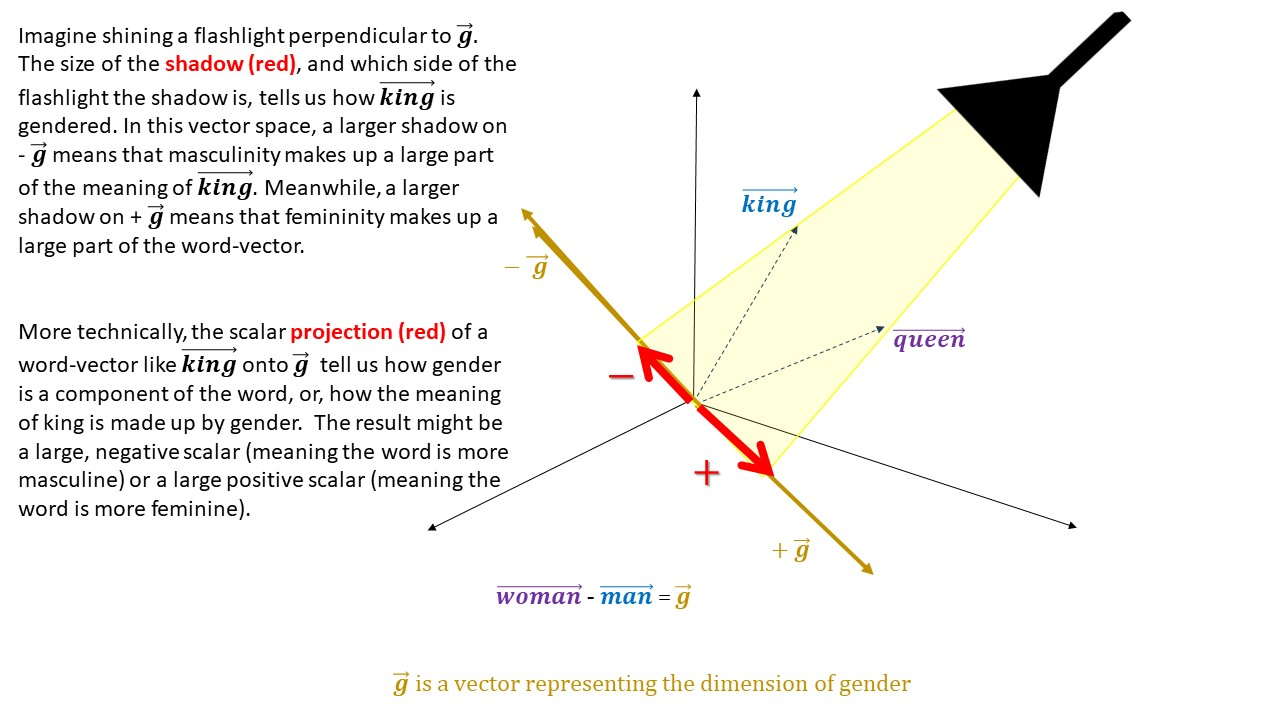

***
__*Projecting a word onto our gender direction:*__

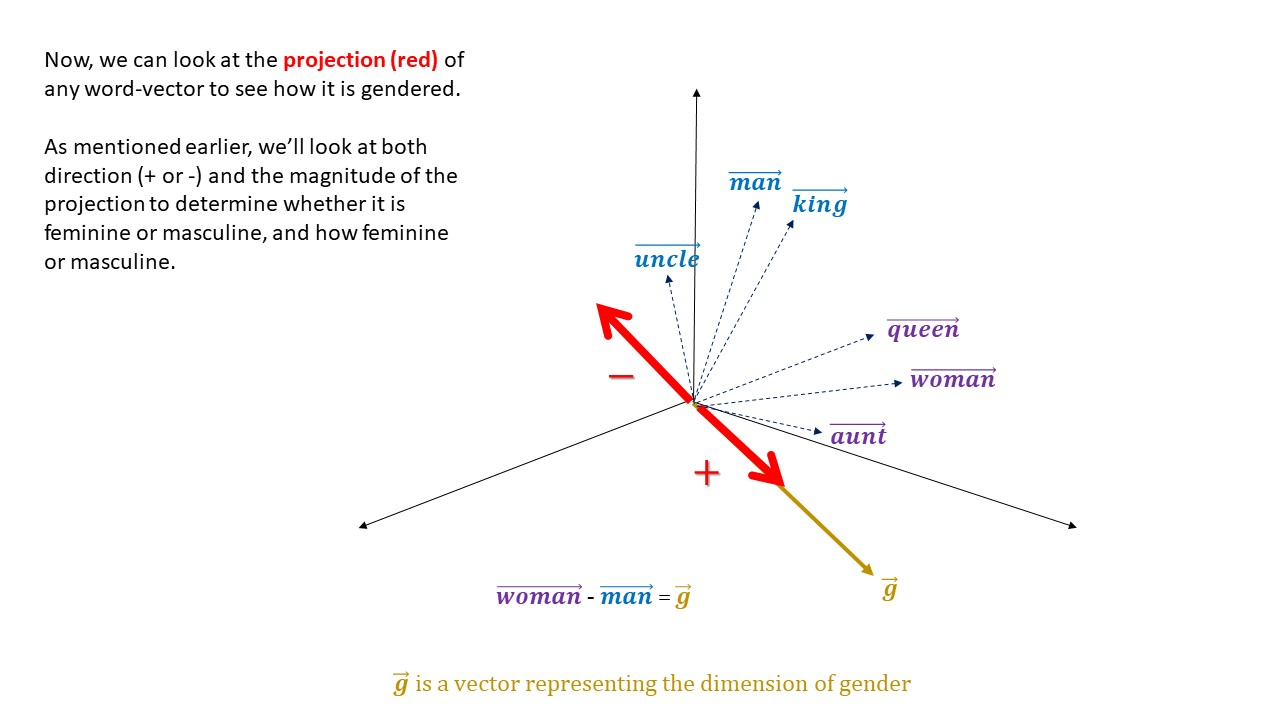


Let's do this for a few words we think will be feminine or masculine, to check that this is working:

First, define some helper functions:

In [79]:
#here's a forumla to project some vector A onto another vector B:
def project(A,B):
    numerator= A.dot(B) #should be a scalar
    denominator= np.linalg.norm(B,1) #should be another scalar
    scalarproject = float(numerator) / denominator #divide numerator by denominator, this gives you the scalar projection (LENGTH aka MAGNITUDE) of b onto a
    return scalarproject
    #if want to get the vector projection (i.e. magnutide and DIRECTION),  result 1 (MAGNITUDE) by vector a, and divded by (norm of A)^2

#here's a formula to make sure our vectors are all the same size 
def normalizeME(vec):
    b= vec.reshape(-1,1)
    c=b/np.linalg.norm(b, ord=2) 
    #print np.linalg.norm(1)
    return c

Do the projections for a few words:

In [80]:
scalarproject_fem_1 = project(currentmodel['queen'],normalizeME(gender_direction_trial)) 
scalarproject_fem_2 = project(currentmodel['womanly'],normalizeME(gender_direction_trial))
scalarproject_masc_1 = project(currentmodel['king'],normalizeME(gender_direction_trial))
scalarproject_masc_2 = project(currentmodel['manly'],normalizeME(gender_direction_trial))

In [81]:
print(scalarproject_fem_1, scalarproject_fem_2, scalarproject_masc_1, scalarproject_masc_2) #take a look at the projections

0.0583079139862 0.0691752387045 -0.023215378155 -0.00890600292843


If this is working on your trained Word2Vec model, you should see that the feminine words lie on one side of the gender direction, and the masculine words on the other side of the gender direction. In my model, for example, all the feminine words have positive scalar projections and all the masculine words have negative scalar projections. 

To find dimensions for other concepts, we just use other training words, like healthy-ill to find a "health" direction. Try it out by modifying the code above! 

### More realistically...

...this method captures the true gender difference alongside other differences and error. To extract a less noisy gender difference, we can use a variety of word pairs beyond woman and man, such as she and he, and then use **Principal Component Analysis** to extract the dominant direction from the various other directions and errors. 

Principal Component Analysis is a method to identify the main directions of variation (principal components) in a group of vectors. The eigenvalue of each principal component corresponds to how much of the variation the principal component explains; the principal component which explains the most variation is called the first principal component. If the group of vectors tend to represent a single direction with some noise (such as a gender direction with noise), then the first principal component will explain most of the variation in the dataset.

You might also try other methods to extract the domininant direction, such as using an average of the gender difference vectors.

The remainder of this notebook tries to extracts a more robust direction using PCA on a large set of training words. We look at three directions in this notebook: gender, morality, health, and SES. This notebook also includes steps to evaluate the robustness of the extracted direction on the training words, and on a new, unseen set of testing words. Finally, we project a new set of words, (obesity keyword) onto the direction to see the meaning of obesity with respect to gender, morality, health, and SES. 

# Now, let's extract a dimension more robustly

<a id='HelperFunctions'></a> 

# Part 2. Some Helper Functions to Extract a Dimension
* We choose a set of word pairs that best represent extremes of the dimennsions you are trying to capture. For example, we use man/woman, he/she, and uncle/aunt, among other word-pairs, to capture a gender dimension. 
* Words may be used more than once if there is no better antonym. Enter the words from each pair below, in order. 
* If you're not sure if your word choices are any good, try cross validation across the word possiblities to see how sensitive the process is to word choice. 

**First, a few helper functions to do a vector proejction and normalize our vectors.**

In [82]:
#a function to do a projection of some vector onto another vector:
def project(A,B): #scalar projection of A onto B
    numerator= A.dot(B) #should be a scalar
    denominator= np.linalg.norm(B,1) #should be another scalar
    scalarproject = float(numerator) / denominator #divide numerator by denominator, this gives you the scalar projection (LENGTH aka MAGNITUDE) of b onto a
    return scalarproject
    #if want to get the vector projection (i.e. magnutide and DIRECTION),  result 1 (MAGNITUDE) by vector a, and divded by (norm of A)^2

#a function to make sure our vectors are all the same size 
def normalizeME(vec):
    b= vec.reshape(-1,1)
    c=b/np.linalg.norm(b, ord=2) 
    #print np.linalg.norm(1)
    return c

**Second, a function to select the dimension and correponding words think represent the two ends of the dimension:**

If a word is not in the vocabulary of the model, this function by default lets you know and then replaces the word with a generic word. For example, if "teenage_girl", or "twin_sister" is not in the vocabulary they will be replaced with the generic feminine word for the gender scale, "woman."

You might prefer to change the generic replacement words, manually curate vocaublary words for your interests or model, or just remove word-pairs if one of the words in the pair doesn't exist. Later in this notebook we'll look at how robust the extracted dimension is to the choice of vocabulary words. 

The training words below were used to capture gender, moral, health, or ses dimensions. 

In [198]:
#a function to select the training words to find a dimensions
def select_training_set(trainingset): #options are: gender, moral, health, ses
    #gender is the main training set used to extract gender
    #gender_2 has fewer precise gender words like "he" vs "she" than set 1,  and some more noise via words that are gendered but less clearcut than Set1. This set was used for experimenting acorss different methods. 
    #gender_3 even fewer precise gender words like "he" vs "she" than set 1,  and same added noise as training set 2. This set was used for experimenting acorss different methods.
    if trainingset=='gender':
        pos_word_list=['womanly', 'my_wife', 'my_mom', 'my_grandmother', 'woman', 'women', 'girl', 'girls', 'her', 'hers', 'herself', 'she', 
            'lady', 'gal', 'gals', 'madame', 'ladies', 'lady',
          'mother', 'mothers', 'mom', 'moms', 'mommy', 'mama', 'ma', 'granddaughter', 'daughter', 'daughters', 'aunt', 'godmother', 
          'grandma', 'grandmothers', 'grandmother', 'sister', 'sisters', 'aunts', 'stepmother', 'granddaughters', 'niece',
          'fiancee', 'ex_girlfriend', 'girlfriends', 'wife', 'wives', 'girlfriend', 'bride', 'brides', 'widow',
           'twin_sister', 'younger_sister', 'teenage_girl', 'teenage_girls', 'eldest_daughter','estranged_wife', 'schoolgirl',
          'businesswoman', 'congresswoman' , 'chairwoman', 'councilwoman', 'waitress', 'hostess', 'convent', 'heiress', 
           'saleswoman', 'queen', 'queens', 'princess', 'nun' , 'nuns', 'heroine', 'actress', 'actresses', 'uterus', 'vagina', 'ovarian_cancer',
           'maternal', 'maternity', 'motherhood', 'sisterhood', 'girlhood', 'matriarch', 'sorority', 
         'older_sister', 'oldest_daughter', 'stepdaughter']
        neg_word_list=['manly', 'my_husband', 'my_dad','my_grandfather', 'man', 'men', 'boy', 'boys', 'him', 'his', 'himself', 'he', 'guy', 'dude',
            'dudes', 'sir', 'guys', 'gentleman','father', 'fathers', 'dad', 'dads', 'daddy', 'papa', 'pa', 'grandson' , 'son', 'sons', 'uncle', 'godfather', 
           'grandpa', 'grandfathers', 'grandfather', 'brother', 'brothers' , 'uncles', 'stepfather', 'grandsons', 'nephew',
           'fiance', 'ex_boyfriend', 'boyfriends', 'husband', 'husbands', 'boyfriend', 'groom', 'grooms', 'widower',
            'twin_brother', 'younger_brother', 'teenage_boy', 'teenage_boys', 'eldest_son', 'estranged_husband', 'schoolboy',
            'businessman', 'congressman', 'chairman', 'councilman', 'waiter', 'host', 'monastery', 'heir', 'salesman', 
            'king', 'kings', 'prince', 'monk', 'monks', 'hero', 'actor', 'actors', 'prostate', 'penis', 'prostate_cancer', 
           'paternal', 'paternity', 'fatherhood', 'brotherhood', 'boyhood', 'patriarch', 'fraternity', 
           'older_brother', 'oldest_son', 'stepson']
        pos_word_replacement='woman' #here's the generic replacement for feminine words
        neg_word_replacement='man' #here's the generic replacement for masculine words
    elif trainingset=='moral':
        pos_word_list= ['good', 'benevolent', 'nice', 'caring', 'conscientious', 'polite', 'fair', 'virtue', 'respect', 'responsible', 
            'selfless', 'unselfish', 'sincere', 'truthful', 'wonderful', 'justice', 'innocent', 'innocence',
           'complement', 'sympathetic', 'virtue', 'right', 'proud', 'pride','respectful', 'appropriate', 'pleasing', 'pleasant', 
            'pure', 'decent', 'pleasant', 'compassion' , 'compassionate', 'constructive','graceful', 'gentle', 'reliable',
           'careful', 'help', 'decent' , 'moral', 'hero', 'heroic', 'heroism', 'honest', 'honesty',
           'selfless', 'humility', 'humble', 'generous', 'generosity', 'faithful', 'fidelity', 'worthy', 'tolerant',
            'obedient', 'pious', 'saintly', 'angelic', 'virginal', 'sacred', 'reverent', 'god', 'hero', 'heroic', 
            'forgiving', 'saintly','holy', 'chastity', 'grateful', 'considerate', 'humane', 
            'trustworthy', 'loyal', 'loyalty', 'empathetic', 'empathy', 'clean', 'straightforward', 'pure']
        neg_word_list= ['bad', 'evil', 'mean', 'uncaring', 'lazy', 'rude', 'unfair', 'sin', 'disrespect','irresponsible', 
           'self_centered', 'selfish', 'insincere', 'lying', 'horrible', 'injustice', 'guilty', 'guilt', 
            'insult', 'unsympathetic', 'vice', 'wrong', 'ashamed', 'shame', 'disrespectful', 'inappropriate', 'vulgar', 'crude', 
            'dirty', 'obscene', 'offensive', 'cruelty','brutal', 'destructive', 'rude', 'harsh', 'unreliable',
            'careless', 'harm', 'indecent', 'immoral', 'coward', 'cowardly', 'cowardice', 'dishonest', 'dishonesty',
            'narcissistic', 'arrogance', 'arrogant', 'greedy', 'greed', 'betray', 'betrayal', 'unworthy', 'intolerant', 
             'defiant', 'rebellious', 'demonic','devilish', 'promiscuous', 'profane', 'irreverent', 'devil', 'villain', 'villainous', 
            'vindictive', 'diabolical', 'unholy', 'promiscuity', 'ungrateful', 'thoughtless', 'inhumane',
            'untrustworthy', 'treacherous', 'treachery', 'callous', 'indifference', 'dirty', 'manipulative', 'impure' ]
        pos_word_replacement='moral' #here's the generic replacement for moral words
        neg_word_replacement='immoral' #here's the generic replacement for immoral words
    elif trainingset=='health':
        pos_word_list= ['fertile', 'help_prevent', 'considered_safe', 'safer', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
            'healthful', 'well_balanced', 'natural', 'healthy', 'athletic','physically_active', 'health',
            'health', 'nutritious','nourishing', 'stronger', 'strong','wellness', 'safe', 'nutritious_food','exercise',
            'physically_fit', 'unprocessed', 'healthier_foods', 'nutritious_foods', 'nutritious', 'nutritious',
           'healthy_eating', 'healthy_diet', 'healthy_diet', 'nourishing', 'nourished', 'regular_exercise', 'safety', 'safe', 
            'helpful', 'beneficial', 'healthy', 'healthy', 'sturdy', 'lower_risk', 'reduced_risk', 'decreased_risk', 'nutritious_foods', 'whole_grains', 'healthier_foods',
            'healthier_foods', 'physically_active', 'physical_activity', 'nourished', 'vitality', 'energetic', 'able_bodied',
            'resilience', 'strength', 'less_prone', 'sanitary', 'clean',  'healing', 'heal', 'salubrious']   
        neg_word_list= ['infertile', 'cause_harm','potentially_harmful','riskier', 'unhealthy', 'sick', 'ill', 'frail', 'sickly', 
            'unhealthful','unbalanced', 'unnatural', 'dangerous', 'sedentary', 'inactive', 'illness', 
            'sickness', 'toxic', 'unhealthy', 'weaker', 'weak', 'illness', 'unsafe', 'unhealthy_foods', 'sedentary',
            'inactive', 'highly_processed', 'processed_foods', 'junk_foods', 'unhealthy_foods', 'junk_foods',
               'processed_foods', 'processed_foods', 'fast_food', 'unhealthy_foods', 'deficient', 'sedentary', 'hazard','hazardous', 
            'harmful', 'injurious',  'chronically_ill', 'seriously_ill', 'frail', 'higher_risk', 'greater_risk', 'increased_risk', 'fried_foods', 'fried_foods',
            'fatty_foods', 'sugary_foods', 'sedentary', 'physical_inactivity', 'malnourished', 'lethargy', 'lethargic', 'disabled',
            'susceptibility', 'weakness', 'more_susceptible', 'filthy', 'dirty', 'harming', 'hurt', 'deleterious']
        pos_word_replacement='healthy' #here's the generic replacement for healthy words
        neg_word_replacement='ill' #here's the generic replacement for unhealthy words
    elif trainingset=='ses':
        pos_word_list=['wealth', 'wealthier', 'wealthiest', 'affluence', 'prosperity', 'wealthy', 'affluent', 'affluent', 'prosperous',
                'prosperous','prosperous','disposable_income',  'wealthy','suburban','luxurious','upscale','upscale', 'luxury', 
                'richest', 'privileged', 'moneyed', 'privileged', 'privileged', 'educated', 'employed', 
                'elite', 'upper_income', 'upper_class', 'employment', 'riches', 'millionaire', 'aristocrat', 'college_educated',
                'abundant', 'lack', 'luxury', 'profitable', 'profit', 'well_educated', 'elites', 'heir', 'well_heeled', 
                'white_collar', 'higher_incomes', 'bourgeois', 'fortunate', 'successful','economic_growth', 'prosper', 'suburbanites']
        neg_word_list= ['poverty', 'poorer', 'poorest', 'poverty', 'poverty', 'impoverished', 'impoverished',  'needy',  'impoverished',
                 'poor', 'needy', 'broke', 'needy', 'slum', 'ghetto', 'slums', 'ghettos', 'poor_neighborhoods', 
                'poorest', 'underserved', 'disadvantaged','marginalized', 'underprivileged', 'uneducated', 'unemployed', 
                'marginalized', 'low_income', 'underclass','unemployment', 'rags', 'homeless', 'peasant', 'college_dropout', 
                'lacking', 'abundance', 'squalor', 'bankrupt', 'debt', 'illiterate' ,'underclass', 'orphan',  'destitute', 
                'blue_collar', 'low_income', 'neediest', 'less_fortunate', 'unsuccessful', 'economic_crisis', 'low_wage', 'homeless']
        pos_word_replacement='wealthy' #here's the generic replacement for rich words
        neg_word_replacement='poor' #here's the generic replacement for poor words
    elif trainingset=='gender_2':
        pos_word_list=[ 'girl', 'girls', 'her', 'hers', 'herself', 'she', 
            'lady', 'gal', 'gals', 'madame', 'ladies', 'lady',
          'mother', 'mothers', 'mom', 'moms', 'mommy', 'mama', 'ma', 'granddaughter', 'daughter', 'daughters', 'aunt', 'godmother', 
          'grandma', 'grandmothers', 'grandmother', 'sister', 'sisters', 'aunts', 'stepmother', 'granddaughters', 'niece',
        'fiancee', 'ex_girlfriend', 'girlfriends', 'wife', 'wives', 'girlfriend', 'bride', 'brides', 'widow',
           'twin_sister', 'younger_sister', 'teenage_girl', 'teenage_girls', 'eldest_daughter','estranged_wife', 'schoolgirl',
        'businesswoman', 'congresswoman' , 'chairwoman', 'councilwoman', 'waitress', 'hostess', 'convent', 'heiress', 
           'saleswoman', 'queen', 'queens', 'princess', 'nun' , 'nuns', 'heroine', 'actress', 'actresses', 'uterus', 'vagina', 'ovarian_cancer',
        'maternal', 'maternity', 'motherhood', 'sisterhood', 'girlhood', 'matriarch', 'sorority', 'mare', 'hen', 'hens', 'filly', 'fillies',
          'deer', 'older_sister', 'oldest_daughter', 'stepdaughter', 'pink',  'cute', 'dependent', 'nurturing', 'hysterical', 'bitch',  'dance', 'dancing'] 
        neg_word_list=['boy', 'boys', 'him', 'his', 'himself', 'he', 'guy', 'dude',
            'dudes', 'sir', 'guys', 'gentleman','father', 'fathers', 'dad', 'dads', 'daddy', 'papa', 'pa', 'grandson' , 'son', 'sons', 'uncle', 'godfather', 
        'grandpa', 'grandfathers', 'grandfather', 'brother', 'brothers' , 'uncles', 'stepfather', 'grandsons', 'nephew',
           'fiance', 'ex_boyfriend', 'boyfriends', 'husband', 'husbands', 'boyfriend', 'groom', 'grooms', 'widower',
            'twin_brother', 'younger_brother', 'teenage_boy', 'teenage_boys', 'eldest_son', 'estranged_husband', 'schoolboy',
            'businessman', 'congressman', 'chairman', 'councilman', 'waiter', 'host', 'monastery', 'heir', 'salesman', 
            'king', 'kings', 'prince', 'monk', 'monks', 'hero', 'actor', 'actors', 'prostate', 'penis', 'prostate_cancer', 
        'paternal', 'paternity', 'fatherhood', 'brotherhood', 'boyhood', 'patriarch', 'fraternity', 'stallion', 'rooster', 'roosters', 'colt',
           'colts', 'bull', 'older_brother', 'oldest_son', 'stepson', 'blue' ,'manly', 'independent', 'aggressive', 'angry', 'jerk', 'wrestle', 'wrestling'  ]
        pos_word_replacement='woman'
        neg_word_replacement='man'
    elif trainingset=='gender_3':
        pos_word_list=['madame', 'ladies', 'lady',
          'mother', 'mothers', 'mom', 'mama', 'granddaughter', 'daughter', 'daughters', 'aunt', 'godmother', 
          'grandma', 'grandmothers', 'grandmother', 'sister', 'sisters', 'aunts', 'stepmother', 'granddaughters', 'niece',
        'fiancee', 'ex_girlfriend', 'girlfriends', 'wife', 'wives', 'girlfriend', 'bride', 'brides', 'widow',
           'twin_sister', 'younger_sister', 'teenage_girl', 'teenage_girls', 'eldest_daughter','estranged_wife', 'schoolgirl',
        'businesswoman', 'congresswoman' , 'chairwoman', 'councilwoman', 'waitress', 'hostess', 'convent', 'heiress', 
           'saleswoman', 'queen', 'queens', 'princess', 'nun' , 'nuns', 'heroine', 'actress', 'actresses', 'uterus', 'vagina', 'ovarian_cancer',
        'maternal', 'maternity', 'motherhood', 'sisterhood', 'girlhood', 'matriarch', 'sorority', 'mare', 'hen', 'hens', 'filly', 'fillies',
          'deer', 'older_sister', 'oldest_daughter', 'stepdaughter', 'pink', 'cute', 'dependent', 'nurturing', 'hysterical', 'bitch',  'dance', 'dancing']
        neg_word_list=['sir', 'guys', 'gentleman','father', 'fathers', 'dad', 'papa', 'grandson' , 'son', 'sons', 'uncle', 'godfather', 
        'grandpa', 'grandfathers', 'grandfather', 'brother', 'brothers' , 'uncles', 'stepfather', 'grandsons', 'nephew',
           'fiance', 'ex_boyfriend', 'boyfriends', 'husband', 'husbands', 'boyfriend', 'groom', 'grooms', 'widower',
            'twin_brother', 'younger_brother', 'teenage_boy', 'teenage_boys', 'eldest_son', 'estranged_husband', 'schoolboy',
            'businessman', 'congressman', 'chairman', 'councilman', 'waiter', 'host', 'monastery', 'heir', 'salesman', 
            'king', 'kings', 'prince', 'monk', 'monks', 'hero', 'actor', 'actors', 'prostate', 'penis', 'prostate_cancer', 
        'paternal', 'paternity', 'fatherhood', 'brotherhood', 'boyhood', 'patriarch', 'fraternity', 'stallion', 'rooster', 'roosters', 'colt',
           'colts', 'bull', 'older_brother', 'oldest_son', 'stepson', 'blue' ,'manly', 'independent', 'aggressive', 'angry', 'jerk', 'wrestle', 'wrestling'  ]
        pos_word_replacement='woman'
        neg_word_replacement='man'
    
    pos_words=[]
    neg_words=[]
    pos_word_list_checked=[]
    neg_word_list_checked=[]
    for i in pos_word_list:
        try:
            pos_words.append(currentmodel[i])
            pos_word_list_checked.append(i)
        except KeyError:
            print(str(i) +  ' was not in this Word2Vec models vocab, and has been replaced with: ' + str(pos_word_replacement) )
            pos_words.append(currentmodel[pos_word_replacement])
            pos_word_list_checked.append(pos_word_replacement)
    for i in neg_word_list:
        try:
            neg_words.append(currentmodel[i])
            neg_word_list_checked.append(i)
        except KeyError:
            print(str(i) +  ' was not in this Word2Vec models vocab, and has been replaced with: ' + str(neg_word_replacement) )
            neg_words.append(currentmodel[neg_word_replacement])
            neg_word_list_checked.append(neg_word_replacement)

    print('\033[1m' + "Number of pos train words: "+ '\033[0m' + str(len(pos_words)) + '\033[1m' + " Number of neg train words: " + '\033[0m' + str(len(neg_words)) )
    train_classes_pos=np.array(np.repeat(1, len(pos_words)).tolist()) #1 is feminine/moral/healthy/rich by default, we will need to find the correct labels inductively
    train_classes_neg=np.array(np.repeat(0, len(neg_words)).tolist()) #0 is masculine/immoral/unhealthy/poor by default, we will need to find the correct labels inductively
    
    pos_words=np.asarray(pos_words)
    neg_words= np.asarray(neg_words)
    return(pos_word_list_checked, neg_word_list_checked, pos_words, neg_words, train_classes_pos, train_classes_neg)

**Third, a function to do Principal Component Analysis (PCA), slightly modified for this application**

Note this function returns a "direction" as well as the eigenvalues found in PCA that can tell you how much signal for this direction there is in the data. We feed this function pos_words (word-vectors corresponding to one end of the dimenion we're interested in, like femininity), and a set of "neg" words (word-vectors corresponding to the opposite end of the dimension we're interested in, like mascunlinity. We also feed it a trained Word2Vec model, and possibly an set if indices to specify the set of training words from pos_words and neg_words we'll use. 

For some help walking through PCA, see [this article](http://sebastianraschka.com/Articles/2014_pca_step_by_step.html) which I modified code from.

By default, the below code finds a single direction (vector) to represent a "dimension." To modify for other sizes of subspaces, consider projecting onto first 2 or more principal components rather than only the first principal component. 

In [84]:
#a function to do PCA on a a bunch of the training word-pairs
def PCA_get_directionVec(pos_words, neg_words, currentmodel, train_index_list=None):
    biggie= []
    
    if train_index_list is not None:
        for i,j in zip(pos_words[train_index_list], neg_words[train_index_list]):
            biggie.append(i-j) #get difference vector for a specific word-pair here
        Ndiff= len(pos_words[train_index_list])
    else:
        for i,j in zip(pos_words, neg_words):
            biggie.append(i-j) #get difference vector for a specific word-pair here
        Ndiff= len(pos_words)
    
    biggie2= np.reshape(biggie, (Ndiff,len(currentmodel['word']))) #now a Ndiff by #dimensions, menasured by len(currentmodel['word']), matrix, can check with print(biggie2.shape)
    biggie2= preprocessing.normalize(biggie2, norm='l2')
    #print(np.linalg.norm(biggie2[0], ord=2)) #a check to make sure vector is normalized in case this was not done in pre-processing of word-vectors, should be length of 1 

    covmat0= [] #this will be used to make the covariance matrix, cov_mat
    for i in range(0,Ndiff):
        covmat0.append(biggie2[i,:])
    cov_mat= np.cov(covmat0) #covariance matrix 
    assert cov_mat.shape == (Ndiff, Ndiff) #a check for dimensions, should be Ndiff by Ndiff. Note we are trying to find one gender direction ammong the 85 noisy directions, that is why doing PCA this way.
    eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat) #get eigenvalues and eigenvectors of covariance matrix

    #for i in range(len(eig_val_cov)):
        #eigvec_cov = eig_vec_cov[:,i].reshape(1,Ndiff).T
        #print('Eigenvector {}: \n{}'.format(i+1 eigvec_cov)) #print out eigenvectors
        #print('Eigenvalue {} from covariance matrix: {}'.format(i+1, eig_val_cov[i])) #print out eigenvalues
    eig_pairs = [[np.abs(eig_val_cov[i]), eig_vec_cov[:,i]] for i in range(len(eig_val_cov))] # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs.sort(key=lambda x: x[0], reverse=True) # Sort the list (eigenvalue, eigenvector) from high to low
    ordered_eig_values=[] 
    for i in eig_pairs:
        ordered_eig_values.append(i[0])
    
    #To Visually confirm that the list is correctly sorted by decreasing eigenvalues:
    #for i in eig_pairs:
        #print(i[0])
    matrix_w = eig_pairs[0][1].reshape(Ndiff,1) #this vector represents a "direction" of pos-neg words
    direction = matrix_w.T.dot(biggie2)  #multiply transpose of this e-vect (principal component) by whole dataset of genderdiffs to get a "gender" direction. for projection inner dimensions must match for dot product
    assert direction.shape == (1,len(currentmodel['word'])) #a dimension check to make sure this direction is the same dimensions as a word-vector in the model
    extracteddirectionVec= np.hstack(normalizeME(direction)) 
    return(extracteddirectionVec, ordered_eig_values)

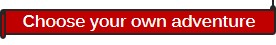

At this point, you can continue to Part 3 to examine the robustness of these methods, or skip right to [Part 4](#Results) to just get to some results.

<a id='Robustness'></a> 
# Part 3. Robustness Checks

**First, let's see how robust our methods are to the specific training words we use. We'll do cross validation on training words:**

Select the dimension you are interested in (gender, moral, health, or ses)

In [96]:
pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('ses') #its ok if words are replaced

upper_income was not in this Word2Vec models vocab, and has been replaced with: wealthy
upper_class was not in this Word2Vec models vocab, and has been replaced with: wealthy
college_educated was not in this Word2Vec models vocab, and has been replaced with: wealthy
well_educated was not in this Word2Vec models vocab, and has been replaced with: wealthy
well_heeled was not in this Word2Vec models vocab, and has been replaced with: wealthy
higher_incomes was not in this Word2Vec models vocab, and has been replaced with: wealthy
economic_growth was not in this Word2Vec models vocab, and has been replaced with: wealthy
poor_neighborhoods was not in this Word2Vec models vocab, and has been replaced with: poor
low_income was not in this Word2Vec models vocab, and has been replaced with: poor
college_dropout was not in this Word2Vec models vocab, and has been replaced with: poor
low_income was not in this Word2Vec models vocab, and has been replaced with: poor
less_fortunate was not in this 

Do **cross validation** to see how accuracy changes at classifying words if we just use a subset of training words to extract the dimension and and look at how the dimension classifies that subset of words and how it classifes the held-out words. This tells us, for example, how robust our methods are to our word choices. 

In [97]:
#cross valdiation
kf= KFold(n_splits=len(pos_words), shuffle=True) 
#n_splits written here is leave-one-wordpair-out cross validation, which is the maximum for n_splits. You could try various lower numbers of n_splits. 
#Note that this cross-validaton is by word-pair, so if we leave out one word-pair from the direction extraction process, 
#we leave out two words on which to "test," giving two test predictions.

testacc=[]
trainacc=[]

for train_index, test_index in kf.split(pos_words): #only need the indices on pos words or neg words, then will be the same indices to use for both
    directionVec= PCA_get_directionVec(pos_words, neg_words, currentmodel, train_index_list=train_index)[0] #first element is the vector, second is the list of ordered-eig values
    
    #In a given model, we don't initially know the "direction" of a dimensions. In other words, we don't know whether a positive projection will be feminine or masculine. So, inductively find the correct labels 1/0. 
    #Consider this assumption that embedded in the code carefully when interpreting accuracy rates. 
    #We learn this rule on the training model and then apply it on the fresh unseen testing model to make sure we're really detecting something.   
    pos_class=[] 
    for word in range(0, len(train_classes_pos[train_index])): #for word in this set of training words
        wordToProject=np.hstack(normalizeME(pos_words[train_index][word]))
        proj=project(wordToProject, directionVec)
        if proj > 0:
            pos_class.append(1) #evidence from this training word that the "positive words" are learned as positive
        elif proj < 0:
            pos_class.append(0) #evidence from this training word that the "positive words" are learned as negative
    
    #Now get predictions on the "training" set of the fold
    predictions_train=[]
    combinedposnegtrain= np.concatenate([pos_words[train_index] ,neg_words[train_index]], axis=0)
    if statistics.mode(pos_class)==1: #if the positive class is mostly 1, keep labels as is. Note that if the positive class is split exactly 50/50 this won't work, but also then accuracy is equal to flip of coin.    
        for word in range(0, len(combinedposnegtrain)):
            wordToProject=np.hstack(normalizeME(combinedposnegtrain[word]))
            proj=project(wordToProject, directionVec)
            if proj > 0:
                predictions_train.append(1)
            elif proj<0:
                predictions_train.append(0)
        classes_train= np.concatenate([train_classes_pos[train_index] , train_classes_neg[train_index]], axis=0)
    elif statistics.mode(pos_class)==0: #if the positive class is mostly -1, reverse labels
        for word in range(0, len(combinedposnegtrain)):
            wordToProject=np.hstack(normalizeME(combinedposnegtrain[word]))
            proj=project(wordToProject, directionVec)
            if proj > 0:
                predictions_train.append(0)
            elif proj<0:
                predictions_train.append(1)
        classes_train= np.concatenate([train_classes_pos[train_index] , train_classes_neg[train_index]], axis=0)
    else:
        print("No clear label")
    
    #Now get predictions on the "testing" set of the fold
    predictions_test=[]
    combinedposnegtest= np.concatenate([pos_words[test_index] ,neg_words[test_index]], axis=0)
    if statistics.mode(pos_class)==1:
        for word in range(0, len(combinedposnegtest)):
            wordToProject=np.hstack(normalizeME(combinedposnegtest[word]))
            proj=project(wordToProject, directionVec)
            if proj > 0:
                predictions_test.append(1)
            elif proj< 0:
                predictions_test.append(0)
        classes_test= np.concatenate([train_classes_pos[test_index], train_classes_neg[test_index]], axis=0)
    elif statistics.mode(pos_class)==0:
        for word in range(0, len(combinedposnegtest)):
            wordToProject=np.hstack(normalizeME(combinedposnegtest[word]))
            proj=project(wordToProject, directionVec)
            if proj > 0:
                predictions_test.append(0)
            elif proj< 0:
                predictions_test.append(1)
        classes_test= np.concatenate([train_classes_pos[test_index], train_classes_neg[test_index]], axis=0)
    else:
        print("No clear label")
    trainacc.append(accuracy_score(classes_train, predictions_train))
    testacc.append(accuracy_score(classes_test, predictions_test))

C:\Users\Alina Arseniev\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


In [197]:
print('\033[1m' +'Mean Accuracy across Training Subsets:'  + '\033[0m'+ str(statistics.mean(trainacc)))
print('\033[1m' +'Standard Deviation of Accuracy across Training Subsets:'  + '\033[0m'+ str(statistics.stdev(trainacc)))
print('\033[1m' +  'Mean Accuracy across Held-Out Subsets: ' + '\033[0m'+ str(statistics.mean(testacc)))
print('\033[1m' +'Standard Deviation of Accuracy across Held-Out Subsets: ' + '\033[0m' + str(statistics.stdev(testacc)))

Mean Accuracy across Training Subsets:0.94
Standard Deviation of Accuracy across Training Subsets:0.003933159639426244
Mean Accuracy across Held-Out Subsets: 0.94
Standard Deviation of Accuracy across Held-Out Subsets: 0.19272482233188631


### Next, let's double check quality of the direction vector by plotting the eigenvalues
If there is indeed a specific "direction" amongst the many, noisy, difference vectors (such as the difference between the word-pair 'man' and 'woman', and between 'uncle' and 'aunt'), we should see that the eigenvalue of first componenent (the "direction") is by far larger than remaining components

In [99]:
#a function to look at the eigenvalues
def eig_plot(subspace, save=False):
    pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set(subspace)
    eigvalues= PCA_get_directionVec(pos_words, neg_words, currentmodel, train_index_list=None)[1] 

    PC_list0= range(1,len(pos_words)+1)
    PC_list= np.arange(len(eigvalues))
    plt.bar( PC_list, eigvalues, align='center')
    plt.title(str("Principal components of "+ subspace +  " differences matrix"))
    #plt.xticks(PC_list, PC_list0 ) #if few PCs and want to label these, add in this in

    #TURN OFF X AXIS TICKS
    plt.tick_params( 
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off') # labels along the bottom edge are off
    plt.xlabel("Principal Component")
    plt.ylabel("Eigenvalue")
    if save==True:
        plt.savefig('PCs_Model.png') #to save a plot as an image
    plt.show()

my_wife was not in this Word2Vec models vocab, and has been replaced with: woman
my_mom was not in this Word2Vec models vocab, and has been replaced with: woman
my_grandmother was not in this Word2Vec models vocab, and has been replaced with: woman
younger_sister was not in this Word2Vec models vocab, and has been replaced with: woman
older_sister was not in this Word2Vec models vocab, and has been replaced with: woman
oldest_daughter was not in this Word2Vec models vocab, and has been replaced with: woman
my_husband was not in this Word2Vec models vocab, and has been replaced with: man
my_dad was not in this Word2Vec models vocab, and has been replaced with: man
my_grandfather was not in this Word2Vec models vocab, and has been replaced with: man
teenage_boy was not in this Word2Vec models vocab, and has been replaced with: man
teenage_boys was not in this Word2Vec models vocab, and has been replaced with: man
older_brother was not in this Word2Vec models vocab, and has been replaced 

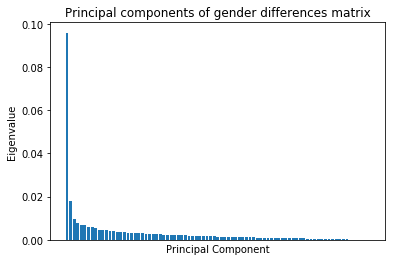

self_centered was not in this Word2Vec models vocab, and has been replaced with: immoral
Number of pos words: 80 Number of neg words: 80


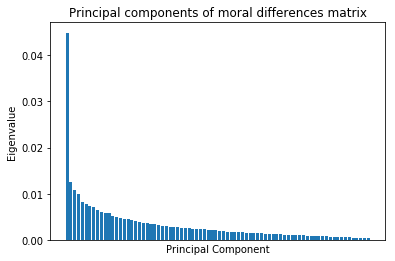

help_prevent was not in this Word2Vec models vocab, and has been replaced with: healthy
considered_safe was not in this Word2Vec models vocab, and has been replaced with: healthy
well_balanced was not in this Word2Vec models vocab, and has been replaced with: healthy
physically_active was not in this Word2Vec models vocab, and has been replaced with: healthy
nutritious_food was not in this Word2Vec models vocab, and has been replaced with: healthy
physically_fit was not in this Word2Vec models vocab, and has been replaced with: healthy
healthy_eating was not in this Word2Vec models vocab, and has been replaced with: healthy
healthy_diet was not in this Word2Vec models vocab, and has been replaced with: healthy
healthy_diet was not in this Word2Vec models vocab, and has been replaced with: healthy
regular_exercise was not in this Word2Vec models vocab, and has been replaced with: healthy
lower_risk was not in this Word2Vec models vocab, and has been replaced with: healthy
reduced_risk w

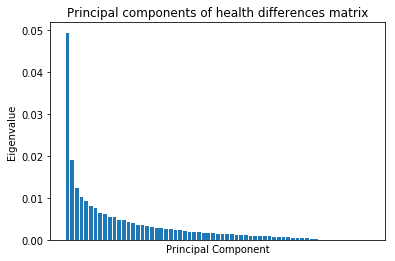

upper_income was not in this Word2Vec models vocab, and has been replaced with: wealthy
upper_class was not in this Word2Vec models vocab, and has been replaced with: wealthy
college_educated was not in this Word2Vec models vocab, and has been replaced with: wealthy
well_educated was not in this Word2Vec models vocab, and has been replaced with: wealthy
well_heeled was not in this Word2Vec models vocab, and has been replaced with: wealthy
higher_incomes was not in this Word2Vec models vocab, and has been replaced with: wealthy
economic_growth was not in this Word2Vec models vocab, and has been replaced with: wealthy
poor_neighborhoods was not in this Word2Vec models vocab, and has been replaced with: poor
low_income was not in this Word2Vec models vocab, and has been replaced with: poor
college_dropout was not in this Word2Vec models vocab, and has been replaced with: poor
low_income was not in this Word2Vec models vocab, and has been replaced with: poor
less_fortunate was not in this 

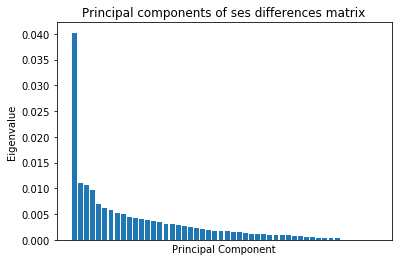

In [100]:
eig_plot('gender')
eig_plot('moral')
eig_plot('health')
eig_plot('ses')

### Last, let's look to see if these directions are unique 

Perhaps they are all just capturing sentiment (good vs bad)?

In [101]:
#extract all four direction vectors:
pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('gender')
genderdirectionVec= PCA_get_directionVec(pos_words, neg_words, currentmodel, train_index_list=None)[0] 

pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('moral')
moraldirectionVec= PCA_get_directionVec(pos_words, neg_words, currentmodel, train_index_list=None)[0] 

pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('health')
healthdirectionVec= PCA_get_directionVec(pos_words, neg_words, currentmodel, train_index_list=None)[0] 

pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('ses')
sesdirectionVec= PCA_get_directionVec(pos_words, neg_words, currentmodel, train_index_list=None)[0] 

my_wife was not in this Word2Vec models vocab, and has been replaced with: woman
my_mom was not in this Word2Vec models vocab, and has been replaced with: woman
my_grandmother was not in this Word2Vec models vocab, and has been replaced with: woman
younger_sister was not in this Word2Vec models vocab, and has been replaced with: woman
older_sister was not in this Word2Vec models vocab, and has been replaced with: woman
oldest_daughter was not in this Word2Vec models vocab, and has been replaced with: woman
my_husband was not in this Word2Vec models vocab, and has been replaced with: man
my_dad was not in this Word2Vec models vocab, and has been replaced with: man
my_grandfather was not in this Word2Vec models vocab, and has been replaced with: man
teenage_boy was not in this Word2Vec models vocab, and has been replaced with: man
teenage_boys was not in this Word2Vec models vocab, and has been replaced with: man
older_brother was not in this Word2Vec models vocab, and has been replaced 

In [102]:
print("Cosine Similarity between gender and morality is: " + str(1 - spatial.distance.cosine(genderdirectionVec, moraldirectionVec))) #similarity is 1-distance
print("Cosine Similarity between gender and health is: " + str(1 - spatial.distance.cosine(genderdirectionVec, healthdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between gender and ses is: " + str(1 - spatial.distance.cosine(genderdirectionVec, sesdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between morality and health is: " + str(1 - spatial.distance.cosine(moraldirectionVec, healthdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between morality and ses is: " + str(1 - spatial.distance.cosine(moraldirectionVec, sesdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between health and ses is: " + str(1 - spatial.distance.cosine(healthdirectionVec, sesdirectionVec))) #similarity is 1-distance

Cosine Similarity between gender and morality is: (0.0348560182694+0j)
Cosine Similarity between gender and health is: (0.033085536526+0j)
Cosine Similarity between gender and ses is: (-0.0202698207139+0j)
Cosine Similarity between morality and health is: (-0.526689453308+0j)
Cosine Similarity between morality and ses is: -0.158042995344
Cosine Similarity between health and ses is: (0.179831082554+0j)


From Word2Vec models used to develop this code, morality and health are quite similar, though not exactly the same. Gender is not similar to any others, and health, morality, and ses have some similarity. Perhaps another future route to improve these directions even more is to find a "sentiment" direction, and find the each the vector *rejection* of morality, health, and SES from sentiment, to "eliminate" sentiment. 

In [103]:
#if you want to save a direction vector you extracted!
np.savetxt("genderdirectionVec_Bolukbasi.csv", genderdirectionVec, delimiter=",") 
np.savetxt("moraldirectionVec_Bolukbasi.csv", moraldirectionVec, delimiter=",") 
np.savetxt("healthdirectionVec_Bolukbasi.csv", healthdirectionVec, delimiter=",") 
np.savetxt("sesdirectionVec_Bolukbasi.csv", sesdirectionVec, delimiter=",")

<a id='Results'></a> 
# Part 4: Let's extract a dimension (gender, morality, health, or socio-economic status) and then see how words are classified according to that dimensions

For each dimension, we'll look at how the dimension classifies the **training** words used to find the dimension and then a fresh set of **testing** words *not* used to find the dimension.

For gender, we'l look at how the dimension classifies some **stereotypically gendered** words, and you can try adding in our own words too. 

Finally, we'll look at how the dimension classifies a set of **words about obesity and body weight**. Is obesity connoted with feminininity or masculinity? Morality or immorality? Health or illness? Wealth or poverty?  Here you can stick in your own words too and see how they are classified. 

Let's get started by defining some more functions:

In [199]:
#a function to select a testing set of words
def select_testing_set(testingset):
    if testingset=='gender':
        test_word_list= ['goddess', 'single_mother', 'girlish', 'feminine', 'young_woman', 'little_girl', 'ladylike', 'my_mother', 
           'teenage_daughter', 'mistress', 'great_grandmother', 'adopted_daughter', 'femininity', 'motherly', 'matronly', 
           'showgirl', 'housewife', 'vice_chairwoman', 'co_chairwoman', 'spokeswoman', 'governess', 'divorcee', 'spinster', 
           'maid', 'countess', 'pregnant_woman', 'landlady', 'seamstress', 'young_girl', 'waif', 'femme_fatale','comedienne',
            'boyish', 'masculine',  'lad', 'policeman', 'macho', 'gentlemanly', 'machismo',  'teenage_son', 
            'beau', 'great_grandfather', 'tough_guy', 'masculinity', 'bad_boy', 'spokesman', 'baron', 'adult_male', 'landlord', 'fireman', 'mailman', 'vice_chairman', 
           'co_chairman','young_man', 'bearded', 'mustachioed', 'con_man', 'homeless_man', 'gent', 'strongman']
        test_classes=np.repeat(1, 31).tolist() #1 is feminine
        masc2=np.repeat(0, 29).tolist() #0 is masculine
        for i in masc2:
            test_classes.append(i) 
    elif testingset=='moral':
        test_word_list= ['great', 'best', 'faith', 'chaste', 'wholesome', 'noble', 'honorable', 'immaculate', 'gracious', 
           'courteous', 'delightful', 'earnest', 'amiable', 'admirable', 'disciplined', 'patience', 'integrity',
            'restraint', 'upstanding', 'diligent', 'dutiful', 'loving', 'righteous','respectable', 'praise', 'devout', 'forthright',
            'depraved', 'repulsive', 'repugnant', 'corruption', 'vicious', 'unlawful', 'outrage',  'shameless', 'perverted',
            'filthy', 'lewd', 'subversive', 'sinister', 'murderous', 'perverse', 
           'monstrous', 'homicidal', 'indignant', 'misdemeanor', 'degenerate', 'malevolent', 'illegal','terrorist','terrorism',  
             'cheated', 'vengeful', 'culpable','vile', 'hateful', 'abuse', 'abusive', 'criminal', 'deviant']
        test_classes=np.repeat(1, 26 ).tolist() #1 is feminine
        masc2=np.repeat(0,34).tolist() #0 is masculine
        for i in masc2:
            test_classes.append(i)
    elif testingset=='health':
        test_word_list= [ 'balanced_diet', 'healthfulness', 'fiber', 'jogging', 'stopping_smoking', 'vigor', 
          'active', 'fit', 'flourishing', 'sustaining', 'hygienic', 'hearty', 'enduring', 'energized', 'wholesome', 
           'holistic', 'healed', 'fitter', 'health_conscious', 'more_nutritious', 'live_longer',  'exercising_regularly',
           'healthier_choices', 'healthy_habits', 'healthy_lifestyle', 'healthful_eating', 'immune', 
            'deadly', 'diseased',  'adverse', 'risky', 'fatal', 'filthy', 'epidemic', 'crippling', 'carcinogenic', 'carcinogen',
           'crippled', 'afflicted', 'contaminated', 'fatigued', 'detrimental', 'bedridden', 'incurable', 'hospitalized',
           'infected', 'ailing', 'debilitated', 'poisons', 'disabling', 'life_threatening', 'debilitating', 
           'chronic_illness', 'artery_clogging', 'hypertension','disease', 'stroke',
            'plague', 'fatty', 'smoking']
        test_classes=np.repeat(1, 26).tolist() #1 is feminine
        masc2=np.repeat(0, 34 ).tolist() #0 is masculine
        for i in masc2:
            test_classes.append(i) 
    elif testingset=='ses':
        test_word_list= ['rich', 'billionaire', 'banker',  'fortune', 'heiress', 'cosmopolitan', 'ornate', 'entrepreneur', 'sophisticated',
                'aristocratic', 'investor', 'highly_educated', 'better_educated',  'splendor', 
               'businessman', 'opulent', 'multimillionaire', 'philanthropist', 'estate', 'estates', 'chateau', 'fortunes', 
               'financier', 'young_professionals','tycoon', 'baron', 'grandeur', 'magnate', 
               'investment_banker', 'venture_capitalist', 'upwardly_mobile', 'highly_skilled', 'yuppies', 'genteel',
                         'homelessness', 'ruin', 'ruined', 'downtrodden', 'less_affluent',
                'housing_project', 'homeless_shelters', 'indigent', 'jobless', 'welfare',  
                'temporary_shelters','housing_projects', 'subsidized_housing', 'starving', 'beggars', 'orphanages',
                'dispossessed', 'uninsured', 'welfare_recipients', 'food_stamps', 
                'malnutrition',  'underemployed', 'disenfranchised', 'servants', 'displaced', 'poor_families'] 
        test_classes=np.repeat(1, 33).tolist()#1 is feminine
        masc2=np.repeat(0, 27).tolist() #0 is masculine
        for i in masc2:
            test_classes.append(i) 
    elif testingset=='gender_stereotypes':
        test_word_list=['petite', 'cooking', 'graceful',  'housework', 'soft', 'whisper', 'flirtatious', 'accepting', 'blonde', 'blond', 'doll', 'dolls','nurse',  'estrogen', 'lipstick','pregnant', 'nanny', 'pink', 
                 'sewing', 'modeling', 'dainty', 'gentle', 'children','pregnancy', 'nurturing', 'depressed', 'nice', 'emotional','depression', 'home', 'kitchen', 'quiet', 'submissive',
                   'soldier', 'army', 'drafted', 'military',   'beard', 'mustache', 'genius', 'engineering', 'math', 
                  'brilliant', 'strong', 'strength',  'politician', 'programmer','doctor', 'sexual', 'aggressive', 
                    'testosterone', 'tall', 'competitive', 'big', 'powerful', 'mean', 'sports', 'fighting', 'confident', 'rough', 'loud', 'worldly',
                   'experienced', 'insensitive', 'ambitious', 'dominant']
        test_classes=np.repeat(1, 33 ).tolist() #1 is feminine
        masc2=np.repeat(0,33).tolist() #0 is masculine
        for i in masc2:
            test_classes.append(i) 
    else:
        print('choose a testing set: gender, moral, health, or ses')
        
    test_words=[]
    test_word_list_checked=[]
    test_classes_checked=[] #new
    for i in test_word_list:
        try:
            test_words.append(currentmodel[i])
            test_word_list_checked.append(i)
            test_classes_checked.append(test_classes[test_word_list.index(i)]) #new
        except KeyError:
            print(str(i) +  ' was not in this Word2Vec models vocab, and has been removed as a test word')
            #index_missing= test_word_list.index(i) #new
            #del(test_classes[index_missing]) 
            #test_words.append(currentmodel[test_word_replacement])
            #test_word_list_checked.append(test_word_replacement)
            #get index of word, and remove this from classes, and do not append to list of vectors and word-list

    test_words= np.asarray(test_words)
    print('\033[1m'+ "Number of test words: " + '\033[0m' + str(len(test_words)))
    return(test_word_list_checked, test_words, test_classes_checked)

In [201]:
#a function to do a projection with a new word list, using a dimension learned on a training set of words
def do_projections(subspace, new_word_list):
    pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set(subspace)
    test_word_list,test_words, test_classes = select_testing_set(subspace)
    directionVec= PCA_get_directionVec(pos_words, neg_words, currentmodel, train_index_list=None)[0] #first element is the vector, second is the list of ordered-eig values
    
    #In a given model, we don't initially know the "direction" of a dimensions. In other words, we don't know whether a positive projection will be feminine or masculine. So, inductively find the correct labels 1/0. 
    #Consider this assumption that embedded in the code carefully when interpreting accuracy rates  
    pos_class=[] 
    for word in range(0, len(train_classes_pos)): #for word in this set of training words
        wordToProject=np.hstack(normalizeME(pos_words[word]))
        proj=project(wordToProject, directionVec)
        if proj > 0:
            pos_class.append(1) #evidence from this training word that the "positive words" are learned as positive
        elif proj < 0:
            pos_class.append(0) #evidence from this training word that the "positive words" are learned as negative
    
    #Now get predictions on the training set
    predictions_train=[]
    projections_train=[]
    combinedposnegtrain= np.concatenate([pos_words, neg_words], axis=0)
    train_classes=np.concatenate([train_classes_pos, train_classes_neg], axis=0) 
    if statistics.mode(pos_class)==1: #if the positive class is mostly 1, keep labels as is. Note that if the positive class is split exactly 50/50 this won't work, but also then accuracy is equal to flip of coin.    
        for word in range(0, len(combinedposnegtrain)):
            wordToProject=np.hstack(normalizeME(combinedposnegtrain[word]))
            proj=project(wordToProject, directionVec)
            projections_train.append(proj)
            if proj > 0:
                predictions_train.append(1)
            elif proj<0:
                predictions_train.append(0)
    elif statistics.mode(pos_class)==0: #if the positive class is mostly -1, reverse labels
        for word in range(0, len(combinedposnegtrain)):
            wordToProject=np.hstack(normalizeME(combinedposnegtrain[word]))
            proj=project(wordToProject, directionVec)
            projections_train.append(-(proj))
            if proj > 0:
                predictions_train.append(0)
            elif proj<0:
                predictions_train.append(1)
    else:
        print("No clear label")

    
    #Now get predictions on the testing set
    predictions_test=[]
    projections_test=[]
    if statistics.mode(pos_class)==1:
        for word in range(0, len(test_words)):
            wordToProject=np.hstack(normalizeME(test_words[word]))
            proj=project(wordToProject, directionVec)
            projections_test.append(proj)
            if proj > 0:
                predictions_test.append(1)
            elif proj< 0:
                predictions_test.append(0)
    elif statistics.mode(pos_class)==0:
        for word in range(0, len(test_words)):
            wordToProject=np.hstack(normalizeME(test_words[word]))
            proj=project(wordToProject, directionVec)
            projections_test.append(-(proj))
            if proj > 0:
                predictions_test.append(0)
            elif proj< 0:
                predictions_test.append(1)
    else:
        print("No clear label")

    trainacc=accuracy_score(train_classes, predictions_train)
    testacc=accuracy_score(test_classes, predictions_test)
    trainacc_N=accuracy_score(train_classes, predictions_train, normalize=False)
    testacc_N=accuracy_score(test_classes, predictions_test, normalize=False)
    
    print('\033[1m' + 'Percent- Training accuracy: '+ '\033[0m'+  str(trainacc) + '\033[1m' + " Testing accuracy: " + '\033[0m'+  str(testacc) )
    print('\033[1m' + 'Number- Training accuracy: ' + '\033[0m'+ str(trainacc_N) + '\033[1m' + " Testing accuracy: " + '\033[0m' + str(testacc_N))
    
    predictions_new_word_list=[]
    projections_new_word_list=[]
    if new_word_list is not None:
        if statistics.mode(pos_class)==1:
            for word in range(0, len(new_word_list)):
                wordToProject=np.hstack(normalizeME(currentmodel[new_word_list[word]]))
                proj=project(wordToProject, directionVec)
                projections_new_word_list.append(proj)
                if proj > 0:
                    predictions_new_word_list.append(1)
                elif proj< 0:
                    predictions_new_word_list.append(0)
        elif statistics.mode(pos_class)==0:
            for word in range(0, len(new_word_list)):
                wordToProject=np.hstack(normalizeME(currentmodel[new_word_list[word]]))
                proj=project(wordToProject, directionVec)
                projections_new_word_list.append(-(proj))
                if proj > 0:
                    predictions_new_word_list.append(0)
                elif proj< 0:
                    predictions_new_word_list.append(1)
        else:
            print("No clear label")
    
    return(np.concatenate([pos_word_list, neg_word_list], axis=0), predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test, test_classes, predictions_new_word_list,  projections_new_word_list)

#### do_projections wraps up a lot of the previous functions we've been using and returns projections and other data you'll want! 

Let's use it, input below whether you want to look at gender, moral, health, or the ses dimensions:

In [202]:
train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test, test_classes, predictions_new_word_list, projections_new_word_list = do_projections('gender', None)

my_wife was not in this Word2Vec models vocab, and has been replaced with: woman
my_mom was not in this Word2Vec models vocab, and has been replaced with: woman
my_grandmother was not in this Word2Vec models vocab, and has been replaced with: woman
younger_sister was not in this Word2Vec models vocab, and has been replaced with: woman
older_sister was not in this Word2Vec models vocab, and has been replaced with: woman
oldest_daughter was not in this Word2Vec models vocab, and has been replaced with: woman
my_husband was not in this Word2Vec models vocab, and has been replaced with: man
my_dad was not in this Word2Vec models vocab, and has been replaced with: man
my_grandfather was not in this Word2Vec models vocab, and has been replaced with: man
teenage_boy was not in this Word2Vec models vocab, and has been replaced with: man
teenage_boys was not in this Word2Vec models vocab, and has been replaced with: man
older_brother was not in this Word2Vec models vocab, and has been replaced 

C:\Users\Alina Arseniev\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


Percent- Training accuracy: 0.911764705882 Testing accuracy: 0.871794871795
Number- Training accuracy: 155 Testing accuracy: 34


#### Some Preliminary Visualization

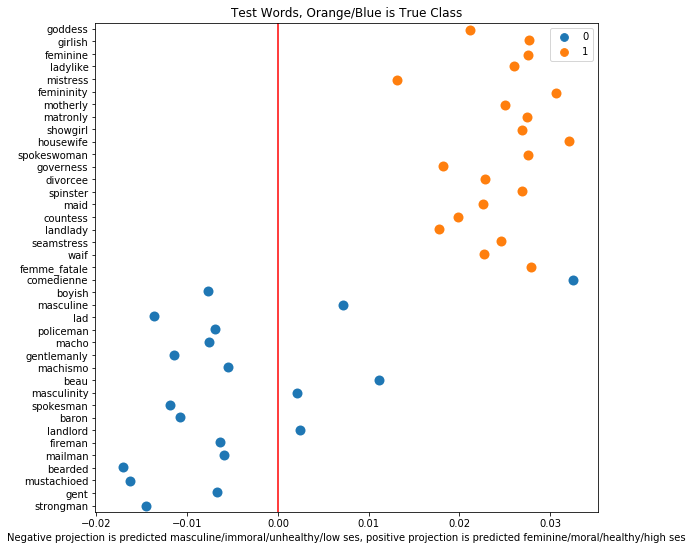

In [203]:
rcParams['figure.figsize'] = 9,9
#xlim([-.03, .03])
myplot= sns.stripplot(projections_test, test_word_list, test_classes, jitter=True, size=10)
plt.axvline(x=0, color='r', linestyle='-')
plt.title('Test Words, Orange/Blue is True Class')
plt.xlabel('Negative projection is predicted masculine/immoral/unhealthy/low ses, positive projection is predicted feminine/moral/healthy/high ses')
plt.show()


#### Lets see how some stereotypically gendered words are classified with this method!
Try adding in other gender stereotypes here!

my_wife was not in this Word2Vec models vocab, and has been replaced with: woman
my_mom was not in this Word2Vec models vocab, and has been replaced with: woman
my_grandmother was not in this Word2Vec models vocab, and has been replaced with: woman
younger_sister was not in this Word2Vec models vocab, and has been replaced with: woman
older_sister was not in this Word2Vec models vocab, and has been replaced with: woman
oldest_daughter was not in this Word2Vec models vocab, and has been replaced with: woman
my_husband was not in this Word2Vec models vocab, and has been replaced with: man
my_dad was not in this Word2Vec models vocab, and has been replaced with: man
my_grandfather was not in this Word2Vec models vocab, and has been replaced with: man
teenage_boy was not in this Word2Vec models vocab, and has been replaced with: man
teenage_boys was not in this Word2Vec models vocab, and has been replaced with: man
older_brother was not in this Word2Vec models vocab, and has been replaced 

C:\Users\Alina Arseniev\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


Percent- Training accuracy: 0.911764705882 Testing accuracy: 0.871794871795
Number- Training accuracy: 155 Testing accuracy: 34


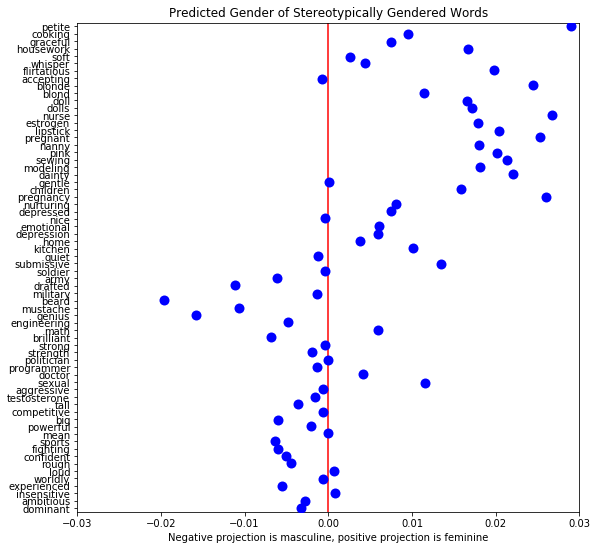

In [204]:
gender_stereotypes_seeifinmodel=['petite', 'cooking', 'graceful',  'housework', 'soft', 'whisper', 'flirtatious', 'accepting', 'blonde', 'blond', 'doll', 'dolls','nurse',  'estrogen', 'lipstick','pregnant', 'nanny', 'pink', 
                 'sewing', 'modeling', 'dainty', 'gentle', 'children','pregnancy', 'nurturing', 'depressed', 'nice', 'emotional','depression', 'home', 'kitchen', 'quiet', 'submissive',
                   'soldier', 'army', 'drafted', 'military',   'beard', 'mustache', 'genius', 'engineering', 'math', 
                  'brilliant', 'strong', 'strength',  'politician', 'programmer','doctor', 'sexual', 'aggressive', 
                    'testosterone', 'tall', 'competitive', 'big', 'powerful', 'mean', 'sports', 'fighting', 'confident', 'rough', 'loud', 'worldly',
                   'experienced', 'insensitive', 'ambitious', 'dominant']
gender_stereotypes= []

#check if these words are in your model
for i in gender_stereotypes_seeifinmodel:
    try:
        currentmodel[i]
        gender_stereotypes.append(i)
    except:
        print(str(i) + " was not in this model's vocabulary and has been removed")
        continue


train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test, test_classes, predictions_new_word_list, projections_new_word_list  = do_projections('gender', gender_stereotypes)

#Visualization
rcParams['figure.figsize'] = 9,9
xlim([-.03, .03])
myplot= sns.stripplot(projections_new_word_list, gender_stereotypes, color= 'blue', jitter=True, size=10)
plt.axvline(x=0, color='r', linestyle='-')
plt.title('Predicted Gender of Stereotypically Gendered Words')
plt.xlabel('Negative projection is masculine, positive projection is feminine')
plt.show()

#### Now lets try with obese words:

Try plugging in your own words here too! Select below whether you want to look at these with respect to gender, moral, health, or ses:

In [205]:
obese_words_seeifinmodel=['obese', 'obesity', 'diabetic', 'diabetes', 'weight', 'overweight', 'thin', 'slender', 'burly',
                'muscular', 'diet', 'dieting', 'health', 'healthy', 'unhealthy', 'fat', 'anorexic', 'anorexia', 'bulimia', 
                'beautiful', 'handsome', 'overeating', 'exercise', 'sedentary', 'bulimic', 'morbidly_obese', 'normal_weight',
                'seriously_overweight']
obese_words= []

#check if these words are in your model
for i in obese_words_seeifinmodel:
    try:
        currentmodel[i]
        obese_words.append(i)
    except:
        print(str(i) + " was not in this model's vocabulary and has been removed")
        continue

train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test, test_classes, predictions_new_word_list, projections_new_word_list  = do_projections('ses', obese_words)

normal_weight was not in this model's vocabulary and has been removed
seriously_overweight was not in this model's vocabulary and has been removed
upper_income was not in this Word2Vec models vocab, and has been replaced with: wealthy
upper_class was not in this Word2Vec models vocab, and has been replaced with: wealthy
college_educated was not in this Word2Vec models vocab, and has been replaced with: wealthy
well_educated was not in this Word2Vec models vocab, and has been replaced with: wealthy
well_heeled was not in this Word2Vec models vocab, and has been replaced with: wealthy
higher_incomes was not in this Word2Vec models vocab, and has been replaced with: wealthy
economic_growth was not in this Word2Vec models vocab, and has been replaced with: wealthy
poor_neighborhoods was not in this Word2Vec models vocab, and has been replaced with: poor
low_income was not in this Word2Vec models vocab, and has been replaced with: poor
college_dropout was not in this Word2Vec models vocab, 

#### More preliminary visualization

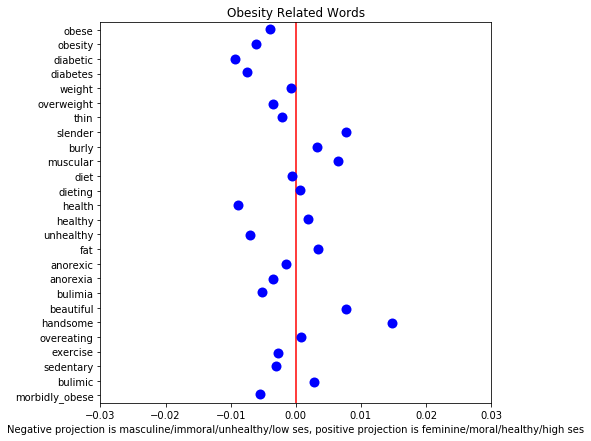

In [187]:
rcParams['figure.figsize'] = 7, 7
xlim([-.03, .03])
myplot= sns.stripplot(projections_new_word_list, obese_words, color= 'blue', jitter=True, size=10)
plt.axvline(x=0, color='r', linestyle='-')
plt.title('Obesity Related Words')
plt.xlabel('Negative projection is masculine/immoral/unhealthy/low ses, positive projection is feminine/moral/healthy/high ses')
plt.show()

#### Write projection for training/testing/obese keywords results to a CSV

In [44]:
#written here for gender, or specify in "do_projections" below for moral, health, or ses
train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test, test_classes, predictions_new_word_list, projections_new_word_list  = do_projections('gender', obese_words)

with open(r'Gender_Results.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(['Gender_Train']*len(train_word_list))  #change the headings as needed for Gender,Moral, Health, SES
    writer.writerow(train_word_list)
    writer.writerow(train_classes)
    writer.writerow(projections_train)
    writer.writerow(predictions_train)
   
    writer.writerow(['Gender_Test']*len(test_word_list)) #change the headings as needed for Gender, Moral, Health, SES
    writer.writerow(test_word_list)
    writer.writerow(test_classes)
    writer.writerow(predictions_test)
    writer.writerow(projections_test)
    
    writer.writerow(['Gender_Obesity']*len(obese_words)) #change the headings as needed for Gender, Moral, Health, SES, and if another set of words other than the obese_words are used here
    writer.writerow(obese_words)
    writer.writerow(predictions_new_word_list)
    writer.writerow(projections_new_word_list)

Number of pos words:85 Number of neg words:85
Number of test words: 60
Percent- Training accuracy: 0.852941176471 Testing accuracy: 0.883333333333
Number- Training accuracy: 145 Testing accuracy: 53
